Modelar o ciclo de cogeração ilustrado abaixo. Permitir que o processo varie de 
0% (desligado) até 100% (completamente ligado).

![Ciclo](img/ciclo.jpeg "Ciclo")

Importando bibliotecas necessárias

In [1]:
from pandas import read_excel, DataFrame, ExcelWriter
from CoolProp.CoolProp import State as st
from numpy import arange, absolute, nan, linspace, argmin, log
from sympy import symbols, ln 
from sympy.solvers.solveset import linsolve, nonlinsolve
from sympy.solvers import solve
import matplotlib.pyplot as plt

try:
    from thermo.chemical import Chemical
    from thermo.mixture import Mixture
    if ModuleNotFoundError==True:
        !pip install thermo
except ModuleNotFoundError:
    pass

from CoolProp.CoolProp import PropsSI as prop

In [2]:
df = read_excel('data.xlsx')
display(df.replace(nan, '-'))

,Temperatura [ºC],Pressão [kPa],Vazão [kg/s],Título [-]
0,485,6495,27.9,-
1,-,900,-,-
2,-,250,-,-
3,51,Saturação,-,-
4,51,Saturação,-,0.0
5,-,250,-,-
6,110,250,-,-
7,-,6495,27.9,-
8,110,250,-,-
9,-,900,-,-


Dados fornecidos

In [3]:
fluido = 'Water'
n_turb, n_pump, n_cald = 0.85, 0.85, 0.85

Inserindo temperatura de saturação na tabela e convertendo para K

In [4]:
T, c = [], 0

for i in df['Temperatura [ºC]']:
    c = c + 1
    try:
        if i == 'Saturação':
            T.insert(c-1, round(prop('T', 'P', df['Pressão [kPa]'][c-1], 'Q', 0, fluido), 2) )
        else:
            T.insert(c-1, i + 273.15)
    except ValueError or NameError:
        print(f'Sem informações de pressão no estado {c}')

Inserindo pressão de saturação na tabela 

In [5]:
P, c = [], 0
for i in df['Pressão [kPa]']:
    c = c + 1
    try:
        if i == 'Saturação':
            P.insert(c-1, round(prop('P', 'T', T[c-1], 'Q', 0, fluido)/10**3,2) )
        else:
            P.insert(c-1, i)
    except ValueError or NameError:
        print(f'Sem informações de temperatura no estado {c}')

Definindo valores de vazão e titulo a partir da tabela de dados

In [6]:
vazao = df['Vazão [kg/s]']
x = df['Título [-]']

## Definindo estados ##

$$ st: Estado $$

In [7]:
def estado(P=None, T=None, x=None, s=None, h=None):
    if x==None and s==None and h==None:
        return st(fluido, {'P': P, 'T': T})
    elif T==None and s==None and h==None:
        return st(fluido, {'P': P, 'Q': x})
    elif T==None and x==None and h==None:
        return st(fluido, {'P': P, 'S': s})
    elif T==None and x==None and s==None:
        return st(fluido, {'P': P, 'H': h})
    else:
        return print('Falta informações')

Definindo estados em função da pressão e temperatura com dados fornecidos

$$st: st(P, T)$$

In [8]:
def st1(p8, t1):
    return estado(P=p8, T=t1)

def st5(tcond):
    return estado(P=P[4], T=tcond)
    
st7 = estado(P=P[6], T=T[6])
st9 = estado(P=P[8], T=T[8])

Definindo estados em função da pressão e titulo com dados fornecidos

$$st: st(P, x)$$

In [9]:
st11 = estado(P=P[10], x=x[10])
st12 = estado(P=P[11], x=x[11])

Definindo estados a partir da equação de eficiência isentrópica para turbinas

$$ \eta_{turb} = \frac{h_{n-1} - h_{n}}{h_{n-1} - h_{ns}} $$

Estado 2

$$ st_{2s}: st_{2s}(P_{2}, S_{1}) $$
$$ h_{2} = h_{1} - \eta_{turb}(h_{1} - h_{2s}) $$
$$ st_{2}: st_{2}(P_{2}, h_{2}) $$

In [10]:
def st2s(p8, t1):
    return estado(P=P[1], s=st1(p8, t1).s)

def st2(p8, t1):
    h2 = st1(p8, t1).h - n_turb*(st1(p8, t1).h - st2s(p8, t1).h)
    return estado(P=P[1], h=h2)

Estado 3

$$ st_{3s}: st_{3s}(P_{3}, S_{2}) $$
$$ h_{3} = h_{2} - \eta_{turb}(h_{2} - h_{3s}) $$
$$ st_{3}: st_{2}(P_{3}, h_{3}) $$

In [11]:
def st3s(p8, t1):
    return estado(P=P[2], s=st2(p8, t1).s)

def st3(p8, t1):
    h3 = st2(p8, t1).h - n_turb*(st2(p8, t1).h - st3s(p8, t1).h)
    return estado(P=P[2], h=h3)

Estado 4

$$ st_{4s}: st_{4s}(P_{4}, S_{3}) $$
$$ h_{4} = h_{3} - \eta_{turb}(h_{3} - h_{4s}) $$
$$ st_{4}: st_{4}(P_{4}, h_{4}) $$

In [12]:
def st4s(p8, t1):
    return estado(P=P[3], s=st3(p8, t1).s)

def st4(p8, t1, Tcond=None):
    if Tcond==None:
        h4 = st3(p8, t1).h - n_turb*(st3(p8, t1).h - st4s(p8, t1).h)
        return estado(P=P[3], h=h4)
    else:
        return estado(P=P[3], T=Tcond)

Definindo estados a partir da equação de eficiência isentrópica para bombas

$$ \eta_{pump} = \frac{h_{ns} - h_{n-1}}{h_{n} - h_{n-1}} $$

Estado 6

$$ st_{6s}: st_{6s}(P_{6}, S_{5}) $$
$$ h_{6} = h_{5} + \frac{h_{6s} - h_{5}}{\eta_{pump}} $$
$$ st_{6}: st_{6}(P_{6}, h_{6}) $$

In [13]:
def st6s(tcond):
    return estado(P=P[5], s=st5(tcond).s)

def st6(tcond):
    h6 = st5(tcond).h + (st6s(tcond).h - st5(tcond).h)/n_pump
    return estado(P=P[5], h=h6)

Estado 8

$$ st_{8s}: st_{8s}(P_{8}, S_{7}) $$
$$ h_{8} = h_{7} + \frac{h_{8s} - h_{7}}{\eta_{pump}} $$
$$ st_{8}: st_{8}(P_{8}, h_{8}) $$

In [14]:
def st8s(p8):
    return estado(P=p8, s=st7.s) #p8 = p1

def st8(p8):
    h8 = st7.h + (st8s(p8).h - st7.h)/n_pump
    return estado(P=P[7], h=h8)

Estado 10

$$ st_{10s}: st_{10s}(P_{10}, S_{9}) $$
$$ h_{10} = h_{9} + \frac{h_{10s} - h_{9}}{\eta_{pump}} $$
$$ st_{10}: st_{10}(P_{10}, h_{10}) $$

In [15]:
st10s = estado(P=P[9], s=st9.s)
h10 = st9.h + (st10s.h - st9.h)/n_pump
st10 = estado(P=P[9], h=h10)

## Obtendo valores de temperatura, pressão, entalpia, entropia e titulo para todos os estados ##

In [16]:
estds = st1(p8=P[0], t1=T[0]), st2(p8=P[0], t1=T[0]), st3(p8=P[0], t1=T[0]), st4(p8=P[0], t1=T[0]), st5(tcond=T[3]), st6(tcond=T[3]), st7, st8(p8=P[7]), st9, st10, st11, st12

temperatura, Tk, pressao, entalpia, entropia, titulo, estados = [], [], [], [], [], [], arange(1, len(estds)+1, 1)

for i in estds: 
    temperatura.append(i.T - 273.15)
    Tk.append(round(i.T, 2))
    pressao.append(i.p)
    entalpia.append(i.h)
    entropia.append(i.s)
    titulo.append(i.Q)

## Resolvendo o sistema de equação das vazões ##

Definindo as variaveis como simbólicas

In [17]:
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12 = symbols('m1 m2 m3 m4 m5 m6 m7 m8 m9 m10 m11 m12')
massas = m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12

$$ \frac{dm_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m} = 0 $$
$$ \frac{dE_{v.c.}}{dt} = \sum_{n=1}^{i} \dot{m}_{in, n}h_{in, n} - \sum_{m=1}^{j} \dot{m}_{out, m}h_{out, m} = 0 $$

$$ \dot{m}_{1}, \dot{m}_{2}, \dot{m}_{3}, \dot{m}_{4}, \dot{m}_{5}, \dot{m}_{6}, \dot{m}_{7}, \dot{m}_{8}, \dot{m}_{9}, \dot{m}_{10}, \dot{m}_{11}, \dot{m}_{12} = \left\{
\begin{array}{lr}
\dot{m}_{1} - 27,9 = 0\\
\dot{m}_{8} - 27,9 = 0\\
\dot{m}_{2} + \dot{m}_{3} + \dot{m}_{4} - \dot{m}_{1} = 0\\
\dot{m}_{12} + \dot{m}_{3} + \dot{m}_{6} - \dot{m}_{7} = 0\\
\dot{m}_{2} + \dot{m}_{10} - \dot{m}_{11} = 0\\
\dot{m}_{2}h_{2} + \dot{m}_{10}h_{10} - \dot{m}_{11}h_{11} = 0\\
\dot{m}_{12}h_{12} + \dot{m}_{3}h_{3} + \dot{m}_{6}h_{6} - \dot{m}_{7}h_{7} = 0\\
\dot{m}_{4} - \dot{m}_{5} = 0\\
\dot{m}_{5} - \dot{m}_{6} = 0\\
\dot{m}_{11} - \dot{m}_{12} = 0\\
\dot{m}_{12} - \dot{m}_{11}F_{processo} = 0\\
\dot{m}_{9} - \dot{m}_{10} = 0
\end{array}
\right. $$

_Resolvendo sistema de equações variando F_processo de 0 a 100% (com passo de 5%)_.
_Cada F_processo resulta em uma lista de vazões (array_m)_. 

In [18]:
var_F = arange(0, 1.05, 0.05)
array_m = []

for c in range(len(var_F)):
    eqs_massas = [ m1 - vazao[0], 
                m8 - vazao[7],
                m2 + m3 + m4 - m1,
                m12 + m3 + m6 - m7,
                m2 + m10 - m11,
                m2*st2(p8=P[0], t1=T[0]).h + m10*st10.h - m11*st11.h,
                m12*st12.h + m3*st3(p8=P[0], t1=T[0]).h + m6*st6(tcond=Tk[3]).h - m7*st7.h,
                m4 - m5,
                m5 - m6,
                m11 - m12,
                m12 - vazao[10]*var_F[c],
                m9 - m10 ]

    array_m.append([round(num, 2) for num in list(linsolve(eqs_massas, massas))[0]])

##Por ex. array_m[0] = lista de vazões em F_processo = 0%, array_m[1] = lista de vazões em F_processo = 5%, e assim sucessivamente. 

_Criando dicionário de dados das vazões e apresentando tabela_

In [19]:
dict_m = {
    'Estado': estados,
    '0%': array_m[0],
    '10%': array_m[2],
    '20%': array_m[4],
    '30%': array_m[6],
    '40%': array_m[8],
    '50%': array_m[10],
    '60%': array_m[12],
    '70%': array_m[14],
    '80%': array_m[16],
    '90%': array_m[18],
    '100%': array_m[20]
}

df_m = DataFrame(dict_m).style.hide(axis='index')
display(df_m)

Estado,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
1,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90
2,0,0.65,1.30,1.95,2.60,3.25,3.90,4.55,5.19,5.84,6.49
3,2.76,2.62,2.48,2.34,2.19,2.05,1.91,1.77,1.62,1.48,1.34
4,25.14,24.63,24.12,23.62,23.11,22.60,22.09,21.59,21.08,20.57,20.07
5,25.14,24.63,24.12,23.62,23.11,22.60,22.09,21.59,21.08,20.57,20.07
6,25.14,24.63,24.12,23.62,23.11,22.60,22.09,21.59,21.08,20.57,20.07
7,27.90,27.94,27.99,28.03,28.08,28.12,28.17,28.21,28.26,28.30,28.35
8,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90,27.90
9,0,0.04,0.09,0.13,0.18,0.22,0.27,0.31,0.36,0.40,0.45
10,0,0.04,0.09,0.13,0.18,0.22,0.27,0.31,0.36,0.40,0.45


Definindo dicionário de dados dos estados e criando tabela

In [20]:
data_st = {
    'Estado': estados,
    'Temperatura [ºC]': temperatura,
    'Pressão [kPa]': pressao,
    'Entalpia [kJ/kg]': entalpia,
    'Entropia [kJ/kg/K]': entropia,
    'Vazão [kg/s]': array_m[20],
    'Titulo [-]': titulo
}

df_st = DataFrame(data_st).style.hide(axis='index').format('{:.2f}', subset=['Temperatura [ºC]', 'Pressão [kPa]', 
                                                                             'Entalpia [kJ/kg]', 'Entropia [kJ/kg/K]', 
                                                                             'Vazão [kg/s]'])

## Resultados ##

In [21]:
display(df_st.format(precision=4, subset=['Titulo [-]']))

Estado,Temperatura [ºC],Pressão [kPa],Entalpia [kJ/kg],Entropia [kJ/kg/K],Vazão [kg/s],Titulo [-]
1,485.00,6495.00,3381.20,6.79,27.90,-1.0000
2,243.27,900.00,2932.08,6.95,6.49,-1.0000
3,127.41,250.00,2714.68,7.05,1.34,0.9992
4,51.00,12.98,2333.14,7.26,20.07,0.8908
5,51.00,12.98,213.52,0.72,20.07,-1.0000
6,51.02,250.00,213.81,0.72,20.07,-1.0000
7,110.00,250.00,461.49,1.42,28.35,-1.0000
8,110.75,6495.00,469.21,1.42,27.90,-1.0000
9,110.00,250.00,461.49,1.42,0.45,-1.0000
10,110.08,900.00,462.30,1.42,0.45,-1.0000


## Trabalho, calor e eficiência ##

$$ \dot{W}_{pump, 1} = \eta_{pump}\dot{m}_{6}(h_{6} - h_{5})$$
$$ \dot{W}_{pump, 2} = \eta_{pump}\dot{m}_{8}(h_{8} - h_{7})$$
$$ \dot{W}_{pump, 3} = \eta_{pump}\dot{m}_{10}(h_{10} - h_{9})$$
$$ \dot{W}_{pump} = \dot{W}_{pump_{1}} + \dot{W}_{pump_{2}} + \dot{W}_{pump_{3}} $$

In [22]:
def W_pump(p8, tcond, m6, m8, m10, p1=None, p2=None, p3=None):
    if p1 is not None:
        return round(m6*(st6(tcond).h - st5(tcond).h)*n_pump, 2)
    if p2 is not None:
        return round(m8*(st8(p8).h - st7.h)*n_pump, 2)
    if p3 is not None:
        return round(m10*(st10.h - st9.h)*n_pump, 2)
    return round(n_pump*(m6*(st6(tcond).h - st5(tcond).h)+ m8*(st8(p8).h - st7.h) + m10*(st10.h - st9.h)), 2)

$$ \dot{W}_{turb} = \eta_{turb}(\dot{m}_{1}h_{1} - (\dot{m}_{2}h_{2} + \dot{m}_{3}h_{3} + \dot{m}_{4}h_{4} ))   $$

In [23]:
def W_turb(p8, t1, m1, m2, m3, m4):
    return round(n_turb*( m1*st1(p8, t1).h - (m2*st2(p8, t1).h + m3*st3(p8, t1).h + m4*st4(p8, t1).h) ), 2)

$$ \dot{W}_{liq} = \dot{W}_{turb} - \dot{W}_{pump}  $$

In [24]:
def W_liq(p8, t1, tcond, m1, m2, m3, m4, m6, m8, m10):
    return W_turb(p8, t1, m1, m2, m3, m4) - W_pump(p8, tcond, m6, m8, m10)

$$ \dot{Q}_{cald} = \dot{m}_{8}(h_{1} - h_{8}) $$

In [25]:
def Q_cald(p8, t1, m8):
    return round(m8*(st1(p8, t1).h - st8(p8).h), 2)

$$ \eta_{ciclo} = \frac{\dot{W}_{liq}}{\dot{Q}_{cald}} $$

In [26]:
def n_ciclo(p8, t1, tcond, m1, m2, m3, m4, m6, m8, m10):
    return round(100*W_liq(p8, t1, tcond, m1, m2, m3, m4, m6, m8, m10)/Q_cald(p8, t1, m8), 5)

Definindo dicionário de dados de trabalho, calor e eficiêcia e criando tabela

In [27]:
data = {
    'W_pump_1 [kW]': [W_pump(p8=P[0], tcond=Tk[3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9], p1=True)],
    'W_pump_2 [kW]': W_pump(p8=P[0], tcond=Tk[3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9], p2=True),
    'W_pump_3 [kW]': W_pump(p8=P[0], tcond=Tk[3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9], p3=True),
    'W_pump [kW]': W_pump(p8=P[0], tcond=Tk[3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]),
    'W_turb [kW]': W_turb(p8=P[0], t1=Tk[0], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3]),
    'W_liq [kW]': W_liq(p8=P[0], t1=Tk[0], tcond=Tk[3], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]),
    'Q_cal [kW]': Q_cald(p8=P[0], t1=Tk[0], m8=array_m[20][7]),
    'η_ciclo [%]': n_ciclo(p8=P[0], t1=Tk[0], tcond=Tk[3], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9])  
}

df_res = DataFrame(data).style.hide(axis='index').format(precision=2)

## Resultados ##

In [28]:
display(df_res)

W_pump_1 [kW],W_pump_2 [kW],W_pump_3 [kW],W_pump [kW],W_turb [kW],W_liq [kW],Q_cal [kW],η_ciclo [%]
4.82,182.96,0.31,188.08,21114.86,20926.78,81244.19,25.75788


## Gráficos ##

Digrama T-s

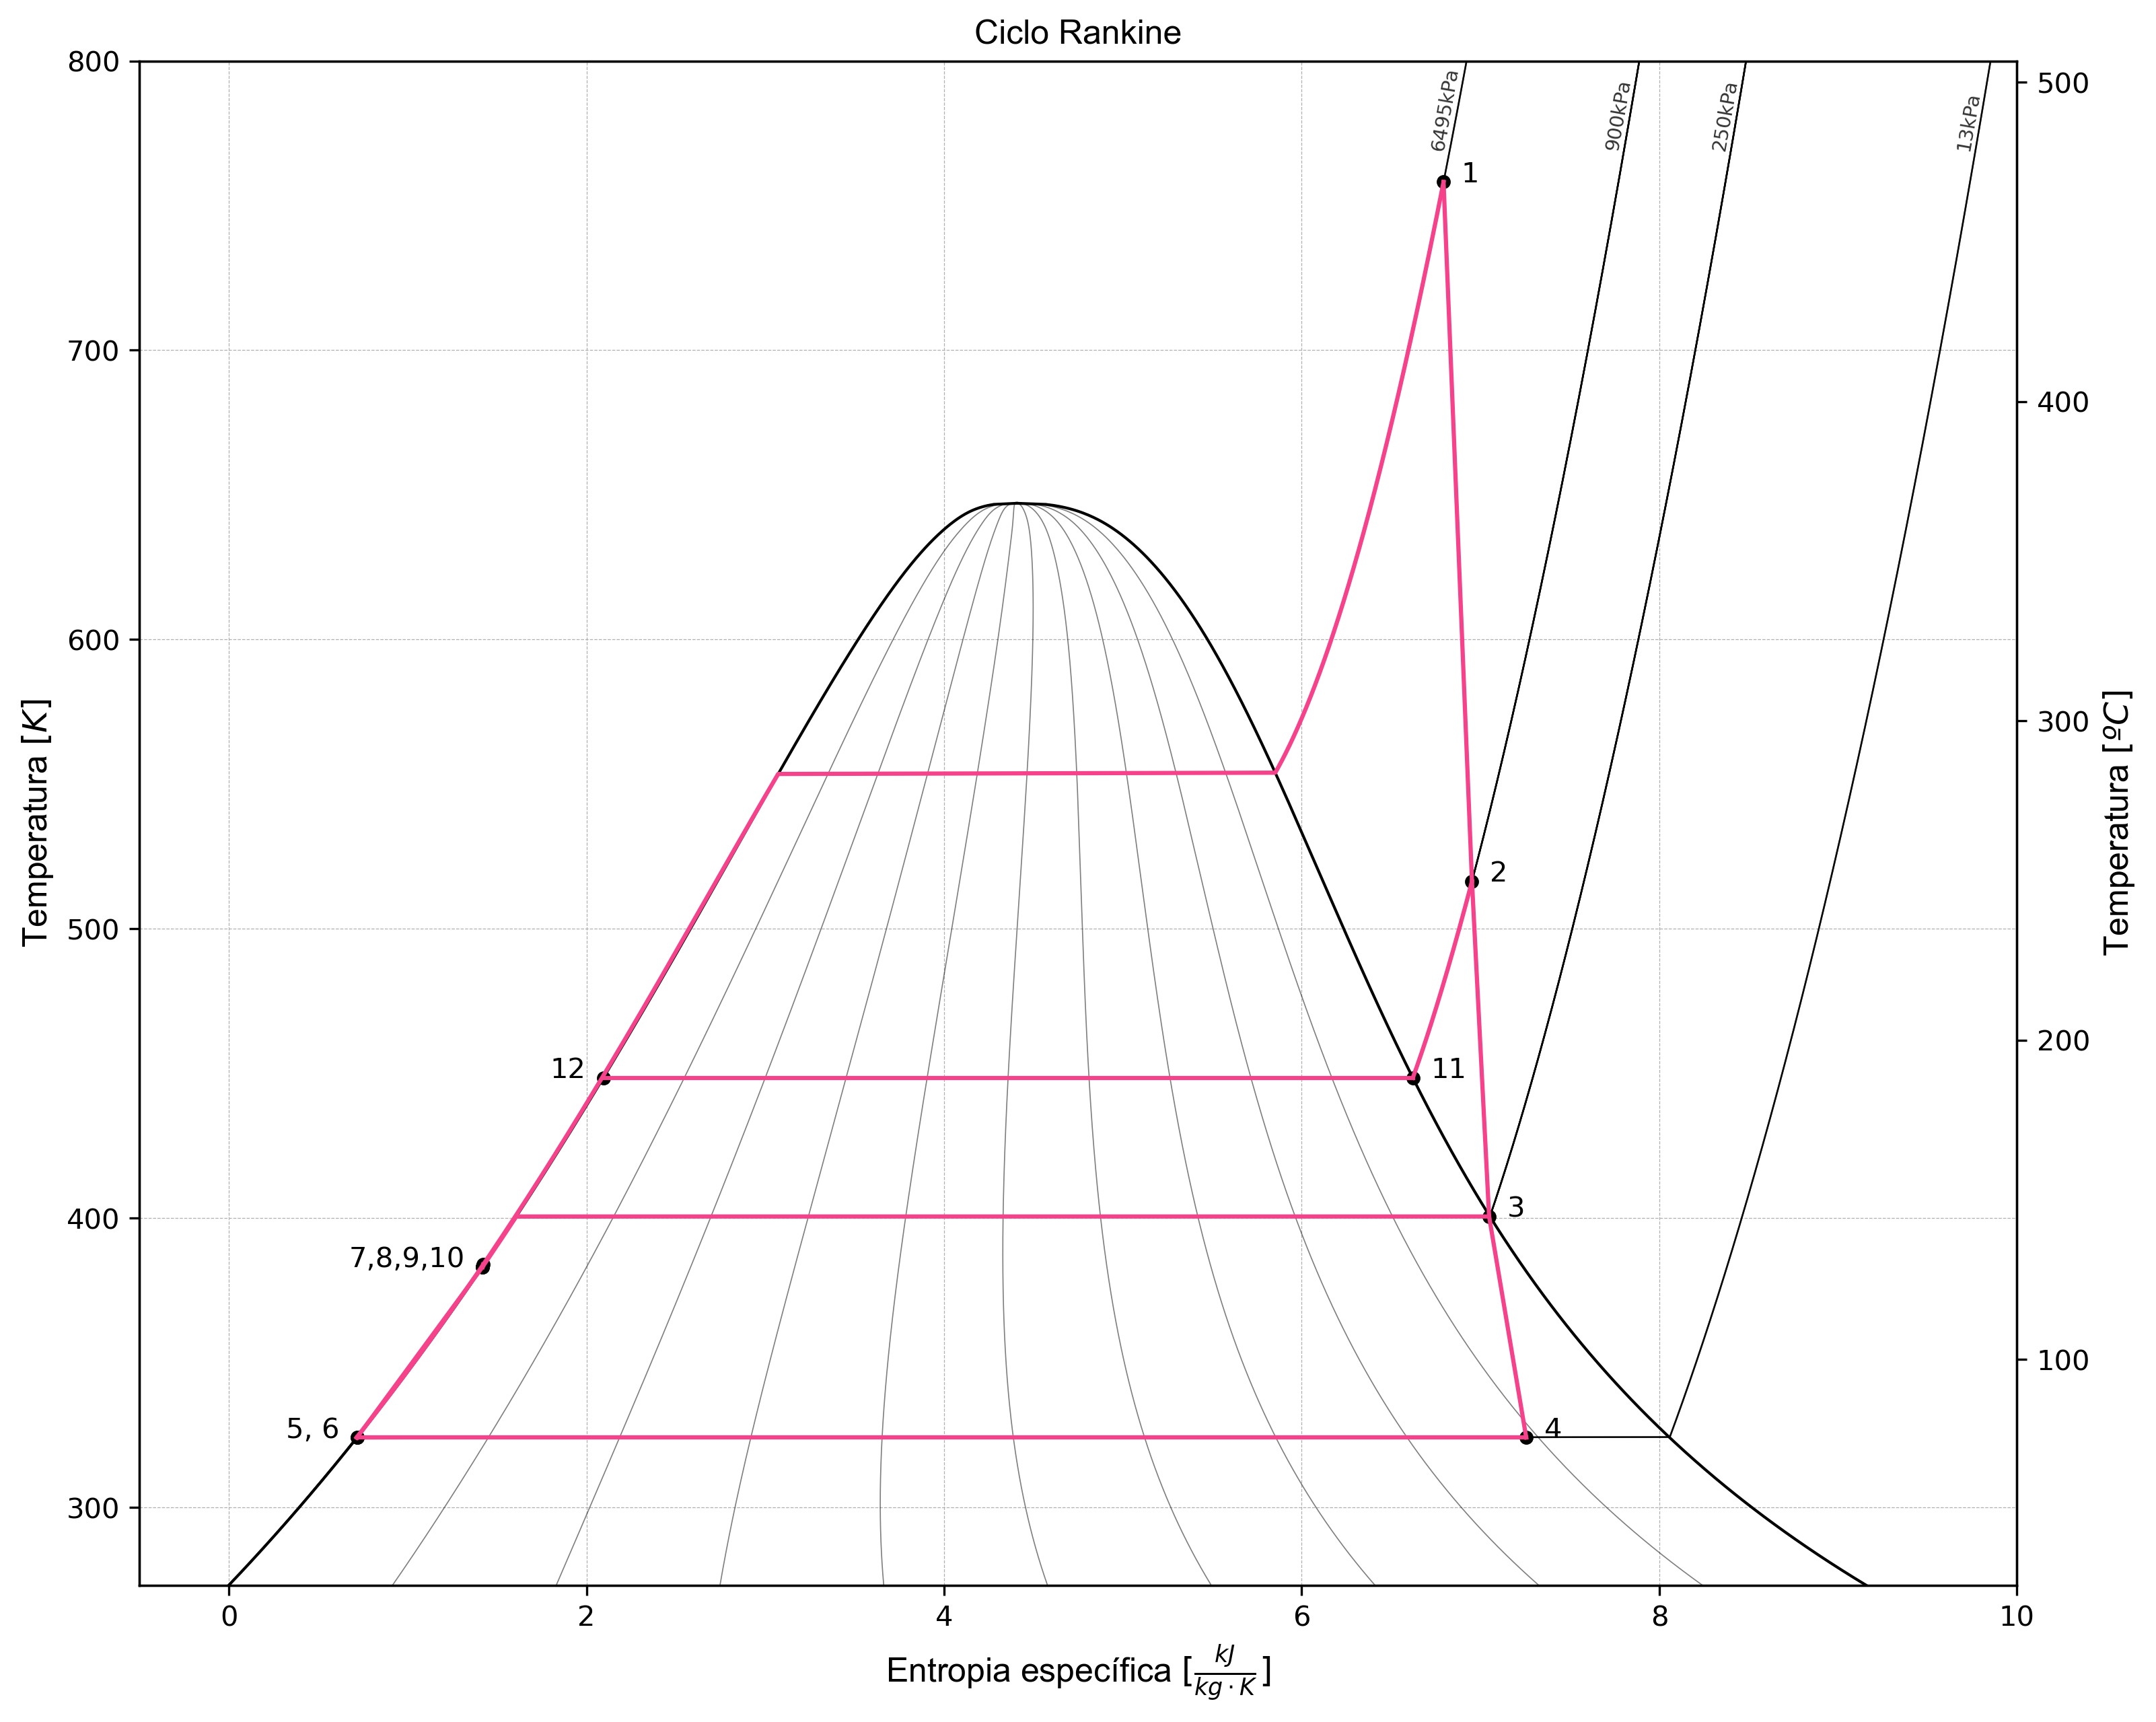

In [29]:
def tsdiagram():
  plt.figure(dpi=300, figsize=(12, 10))

  #limite dos eixos
  plt.ylim(273.15, 800)
  plt.xlim(-0.5, 10)

  Tmin, Tcrit, Pcrit = prop('Tmin', fluido), prop('Tcrit', fluido), prop('Pcrit', fluido)
  T_array = linspace(Tmin, Tcrit, 10**3)

  #Linhas de entropia
  for c in arange(0.1, 1, 0.1):
    s = prop('S', 'T', T_array, 'Q', c, fluido)/10**3
    plt.plot(s, T_array, color='black', alpha=0.5, lw=0.4)

  #Linhas de pressão constante:
  for c in P:
    s = prop('S', 'T', linspace(Tmin, 800, 10**3), 'P', c*10**3, fluido)/10**3
    plt.plot(s, linspace(Tmin, 800, 10**3), color='black',alpha=0.8, lw=0.6)
    
  #Inserindo nome nas linhas de pressão constante
  def entropy(p):
    return prop('S', 'P', p*10**3, 'T', 770, fluido)/10**3

  plt.text(entropy(p=P[0])-0.12, 770, f'{P[0]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)
  plt.text(entropy(p=P[1])-0.12, 770, f'{P[1]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)
  plt.text(entropy(p=P[2])-0.12, 770, f'{P[2]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)
  plt.text(entropy(p=P[3])-0.12, 770, f'{P[3]:.0f}kPa', fontsize=7, rotation = -280, alpha=0.8)

  #Domo:
  s = prop('S','T' ,T_array ,'Q',0 ,fluido)/10**3
  plt.plot(s, T_array, color='black', lw=1)
  s = prop('S', 'T', T_array, 'Q', 1, fluido)/10**3
  plt.plot(s, T_array, color='black', lw=1)

  #Inserindo pontos
  plt.plot(entropia, Tk, 'o', color='black', markersize=4, alpha=1) 

  #Ciclo
  T_var = linspace(max(Tk), min(Tk), 1000)
  s = prop('S','P', P[0]*10**3, 'T',T_var,'Water')/10**3
  plt.plot(s,T_var,'#f5428a',lw=1.5)

  for c in range(len(estados)-3):
      c = c+1
      plt.plot([entropia[c-1], entropia[c]],[Tk[c-1], Tk[c]],color='#f5428a',lw=1.5)

  plt.plot([entropia[10], entropia[11]],[Tk[10], Tk[11]],color='#f5428a',lw=1.5)

  #estado 3 - 7
  s = linspace(entropia[2], entropia[6], 1000)
  Temp = prop('T','S',s*10**3,'P', P[2]*10**3, fluido)
  plt.plot(s,Temp, color='#f5428a', lw=1.5)[0]

  #estado 2 - 11
  s = linspace(entropia[1], entropia[10], 1000)
  Temp = prop('T','S',s*10**3,'P', P[1]*10**3, fluido)
  plt.plot(s,Temp,'#f5428a', lw=1.5)[0]

  #Inserindo nome nos pontos
  plt.text(entropia[0]+0.1, Tk[0], '1',ha='left')
  plt.text(entropia[1]+0.1, Tk[1], '2',ha='left')
  plt.text(entropia[2]+0.1, Tk[2], '3',ha='left')
  plt.text(entropia[3]+0.1, Tk[3], '4',ha='left')
  plt.text(entropia[4]-0.1, Tk[4], '5, 6',ha='right')
  plt.text(entropia[6]-0.1, Tk[6], '7,8,9,10',ha='right')
  plt.text(entropia[10]+0.1, Tk[10], '11',ha='left')
  plt.text(entropia[11]-0.1, Tk[11], '12',ha='right')

  plt.grid(ls='--', lw=0.3)
  plt.title('Ciclo Rankine', fontname='Arial', fontsize=12)
  plt.xlabel(r'Entropia específica $[\frac{kJ}{kg \cdot K}]$', fontname='Arial', fontsize=12)
  plt.ylabel(r'Temperatura $[K]$', fontname='Arial', fontsize=12)

  plt.twinx()
  plt.ylabel(r'Temperatura $[ºC]$',color='black', fontname='Arial', fontsize=12)
  plt.plot(temperatura, alpha=0)
  plt.tick_params(axis='y', labelcolor='black', grid_alpha=0)


  plt.show()

tsdiagram()

_Gráfico da eficiência em função da pressão da bomba 2_

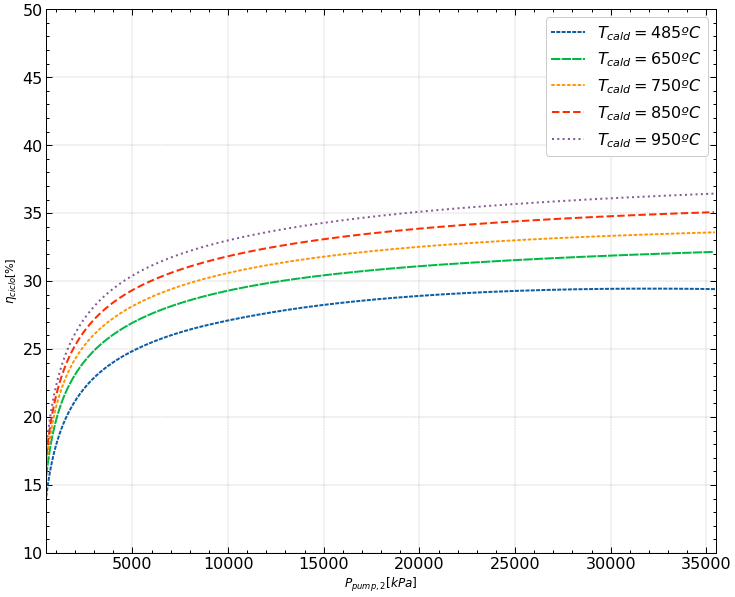

In [30]:
def np2():
    #Definindo variação de pressão da bomba 2 no gráfico, de 500 a 3500, com passo de 100.
    pressure = arange(500, 35000+500, 100)   

    #Criando listas vazias para adcionar dados das eficiencia para as temperaturas T1, T=650ºC, T=750ºC, T=850ºC e T=950ºC, variando a pressão da bomba 2.
    array_n_t1, array_n_t650, array_n_t750, array_n_t850, array_n_t950 = [], [], [], [], []   

    #Acidionando dados as listas vazias
    for c in range(len(pressure)):
        array_n_t1.append(n_ciclo(p8=pressure[c], t1=Tk[0], tcond=Tk[3], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]))
        array_n_t650.append(n_ciclo(p8=pressure[c], t1=923.15, tcond=Tk[3], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]))
        array_n_t750.append(n_ciclo(p8=pressure[c], t1=1023.15, tcond=Tk[3], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]))
        array_n_t850.append(n_ciclo(p8=pressure[c], t1=1123.15, tcond=Tk[3], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]))
        array_n_t950.append(n_ciclo(p8=pressure[c], t1=1223.15, tcond=Tk[3], m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]))

    #Montando o gráfico
    plt.style.use(['science', 'notebook', 'grid'])
    plt.figure(figsize=(12, 10))

    plt.plot(pressure, array_n_t1, ls=':', dash_capstyle='projecting', label=r'$T_{cald}=485ºC$')
    plt.plot(pressure, array_n_t650, ls='--',dash_capstyle='projecting', label=r'$T_{cald}=650ºC$')
    plt.plot(pressure, array_n_t750, ls=':',dash_capstyle='round', label=r'$T_{cald}=750ºC$')
    plt.plot(pressure, array_n_t850, ls='--',dash_capstyle='butt', label=r'$T_{cald}=850ºC$')
    plt.plot(pressure, array_n_t950,  ls=':',dash_capstyle='butt', label=r'$T_{cald}=950ºC$')

    plt.xlim(500, 35000+500)
    plt.ylim(10, 50)

    plt.ylabel(r'$\eta_{ciclo}$[%]', fontname='Arial', fontsize=12)
    plt.xlabel(r'$P_{pump, 2} [kPa]$', fontname='Arial', fontsize=12)
    plt.grid(ls='--', lw=0.3)

    plt.legend()
    plt.show()

np2()

_Gráfico da eficiência em função da temperatura do condensador_

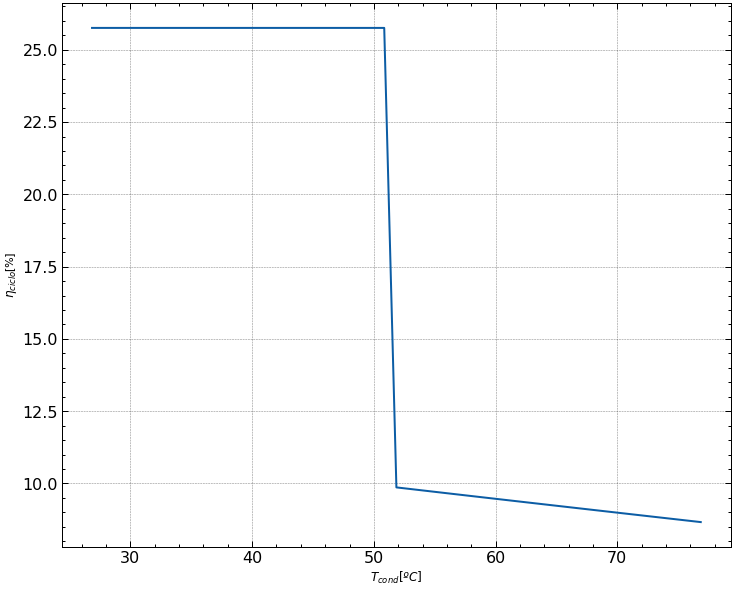

In [31]:
def ntcond():
    
    #Definindo variação da temperatura do condesador no gráfico
    tcondensador = arange(300-273.15, 350+1-273.15, 1)

    #Criando lista vazia para adicionar dados da eficiencia em função da temperatura do condensador
    n_ciclo_tcond = []

    #Adicionando dados a lista vazia
    for c in range(len(tcondensador)):
        n_ciclo_tcond.append(n_ciclo(p8=P[7], t1=Tk[0], tcond=tcondensador[c] + 273.15, m1=array_m[20][0], m2=array_m[20][1], m3=array_m[20][2], m4=array_m[20][3], m6=array_m[20][5], m8=array_m[20][7], m10=array_m[20][9]))

    #Montando o gráfico
    plt.style.use(['science', 'notebook', 'grid'])
    plt.figure(figsize=(12, 10))
    
    plt.plot(tcondensador, n_ciclo_tcond)

    plt.ylabel(r'$\eta_{ciclo}$[%]', fontname='Arial', fontsize=12)
    plt.xlabel(r'$T_{cond} [ºC]$', fontname='Arial', fontsize=12)

    plt.plot()

ntcond()

_Gráfico da vazão nos estados em função de F_processo_

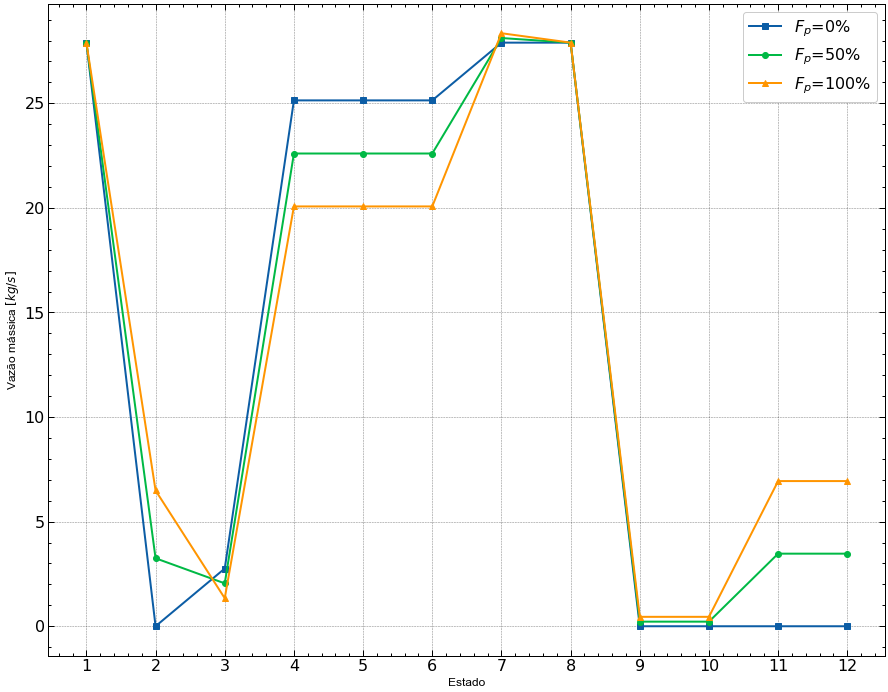

In [32]:
def nfpro():
    figure = plt.figure(figsize=(15, 12))

    plt.plot(estados, array_m[0], marker='s', label = r'$F_p$={:.0f}%' .format(var_F[0]*100))
    plt.plot(estados, array_m[10], marker='o', label = r'$F_p$={:.0f}%' .format(var_F[10]*100))
    plt.plot(estados, array_m[20], marker='^',label = r'$F_p$={:.0f}%' .format(var_F[20]*100))
    plt.ylabel(r'Vazão mássica $[kg/s]$', fontname='Arial', fontsize=12)
    plt.xlabel('Estado', fontname='Arial', fontsize=12)
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    plt.legend()
    plt.show()

nfpro()

Fazer a modelagem com condensador para que sua temperatura de condensação 
varie conforme a vazão de condensado. Mostrar essa variação.

![Condensador](img/Condensador.jpeg "Condensador")

_Dados fornecidos do condesador_ 

In [33]:
tc_in = 29 + 273.15     #K
tc_out = 39.5 + 273.15  #K
th_in = 51 + 273.15     #K   
Vc = 4500               #m^3/h

$\epsilon$: Efetividade

$$ \epsilon = \frac{T_{c, out} - T_{c, in}}{T_{h, in} - T_{c, in}} $$

$$ T_{h, in} = T_{cond} $$

In [34]:
def e(tcond):
    return (tc_out - tc_in)/(tcond - tc_in)

$$ NTU = -\ln{(1 - \epsilon)} $$

In [35]:
def ntu(tcond):
    return -log(1 - e(tcond))

$$ UA_{s} = NTU*C_{min} $$
$$ C_{min} = \frac{\dot{V}_{c} \rho_{c, med} c_{p, med}}{3600} $$
$$ c_{p, med} = \frac{c_{p, in} + c_{p, out}}{2} $$
$$ \rho_{c, med} : \rho_{c, med}(P_{atm}, T_{c,med}) $$
$$ c_{p, in} : c_{p, in}(P_{atm}, T_{c, in}) $$
$$ c_{p, out} : c_{p, out}(P_{atm}, T_{c, out}) $$

In [36]:
def UAs(tcond):
    cp_in = prop('CPMASS', 'P', 101325, 'T', tc_in, fluido)/10**3    #kJ/kg*K
    cp_out = prop('CPMASS', 'P', 101325, 'T', tc_out, fluido)/10**3  #kJ/kg*K
    pc = prop('D', 'P', 101325, 'T', (tc_in + tc_out)/2 ,fluido)     #kg/m^3
    cp_med = (cp_in + cp_out)/2                                      #kJ/kg*K
    C_min = (Vc*pc*cp_med)/3600                                      #kJ/K*s
    return ntu(tcond)*C_min  #kJ/K*s

$$ \delta T_{m} = \frac{\delta T_{1} - \delta T_{2}}{ln{\frac{\delta T_{1}}{\delta T_{2}}}} $$

In [37]:
def varTm(tcond):
    varT1 = tcond - tc_in
    varT2 = tcond - tc_out
    return (varT1 - varT2)/log(varT1/varT2)

$$ \dot{Q} = UA_{s} * \delta T_{m} $$
$$ \dot{Q} : \dot{Q}(T_{cond}) $$

In [38]:
def Qcond(tcond, vazao_m):
    return UAs(tcond)*varTm(tcond)  #kW

$$ \delta T_{1}, \delta T_{2}, \delta T_{m}, T_{cond}, \dot{Q}_{cond} = \left\{
\begin{array}{lr}
\delta T_{1} - T_{cond} + T_{c, in} = 0\\
\delta T_{2} - T_{cond} + T_{c, out} = 0\\
\delta T_{m} - (\frac{\delta T_{1} - \delta T_{2}}{ln(\delta T_{1}/\delta T_{2})}) = 0\\
\dot{Q} - UA_{s}\delta T_{m}  = 0\\
\dot{Q} - \dot{m}_4(h_{4} - h_{5}) = 0
\end{array}
\right. $$

Fazendo as seguintes considerações: 
$$ h_{5}: h_{5}(T_{cond} = constante) $$
$$ UA_{s}: UA_{s}(T_{cond} = constante) $$

In [39]:
ΔT1, ΔT2, ΔTm, T_cond, Q_cond, h4 = symbols('ΔT1 ΔT2 ΔTm Tcond Qcond h4')

array_solved = []

for c in range(len(var_F)):

    Eq_cond = [-ΔT1+(T_cond-tc_in), 
            -ΔT2+(T_cond-tc_out), 
            -ΔTm+(ΔT1-ΔT2)/(ln(ΔT1/ΔT2)), 
            -Q_cond+UAs(tcond=Tk[3])*ΔTm, 
            -Q_cond+array_m[c][3]*(entalpia[3]-st5(tcond=Tk[3]).h)]

    array_solved.append([round(num, 3) for num in list(nonlinsolve(Eq_cond, ΔT1, ΔT2, ΔTm, T_cond, Q_cond))[0]])

## Resultados ##

Criando dicionário de dados e apresentando tabela de ΔT1, ΔT2, ΔTm, T_cond e Q_cond para cada F_processo

In [40]:
array_m_nseimais = []

for j in range(len(array_solved)):
    for c in range(len(var_F)):
        eqs_massas = [ m1 - vazao[0], 
                    m8 - vazao[7],
                    m2 + m3 + m4 - m1,
                    m12 + m3 + m6 - m7,
                    m2 + m10 - m11,
                    m2*st2(p8=P[0], t1=T[0]).h + m10*st10.h - m11*st11.h,
                    m12*st12.h + m3*st3(p8=P[0], t1=T[0]).h + m6*st6(tcond=array_solved[j][3]).h - m7*st7.h,
                    m4 - m5,
                    m5 - m6,
                    m11 - m12,
                    m12 - vazao[10]*var_F[c],
                    m9 - m10 ]

    array_m_nseimais.append([round(num, 2) for num in list(linsolve(eqs_massas, massas))[0]])

In [41]:
varT_st4 = []
varm_st4 = []

for c in range(len(array_solved)):
    varT_st4.append(round(st4(p8=P[7], t1=T[0],Tcond=array_solved[c][3]).h, 2))
    varm_st4.append(array_m_nseimais[c][3])

for c in range(len(array_solved)):
    array_solved[c].append(varT_st4[c])
    array_solved[c].append(varm_st4[c])

In [42]:
data_solved = {
    'F_processo': [T_cond, Q_cond, h4, m4],
    '0%': array_solved[0][3:7],
    '5%': array_solved[1][3:7],
    '10%': array_solved[2][3:7],
    '15%': array_solved[3][3:7],
    '20%': array_solved[4][3:7],
    '25%': array_solved[5][3:7],
    '30%': array_solved[6][3:7],
    '35%': array_solved[7][3:7],
    '40%': array_solved[8][3:7],
    '45%': array_solved[9][3:7],
    '50%': array_solved[10][3:7],
    '55%': array_solved[11][3:7],
    '60%': array_solved[12][3:7],
    '65%': array_solved[13][3:7],
    '70%': array_solved[14][3:7],
    '75%': array_solved[15][3:7],
    '80%': array_solved[16][3:7],
    '85%': array_solved[17][3:7],
    '90%': array_solved[18][3:7],
    '95%': array_solved[19][3:7],
    '100%': array_solved[20][3:7],
}

df_solved = DataFrame(data_solved).style.hide(axis='index').format(precision=2)
display(df_solved)

F_processo,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,100%
Tcond,323.790,323.632,323.481,323.329,323.172,323.021,322.870,322.713,322.563,322.412,322.256,322.106,321.950,321.800,321.650,321.494,321.345,321.196,321.041,320.892,320.744
Qcond,53286.841,52735.721,52205.818,51675.915,51125.312,50595.409,50065.505,49514.385,48984.482,48454.579,47903.459,47373.556,46822.436,46292.532,45762.629,45211.509,44681.606,44151.703,43600.583,43070.679,42540.776
h4,212.02,211.36,210.73,210.09,209.43,208.80,208.17,207.52,206.89,206.26,205.60,204.98,204.32,203.70,203.07,202.42,201.79,201.17,200.52,199.90,199.28
m4,20.05,20.05,20.04,20.04,20.03,20.03,20.02,20.02,20.01,20.01,20.0000000000000,20.0000000000000,19.99,19.99,19.98,19.98,19.97,19.97,19.96,19.96,19.95


## Gráficos ##

Gráfico T_cond em função de F_processo

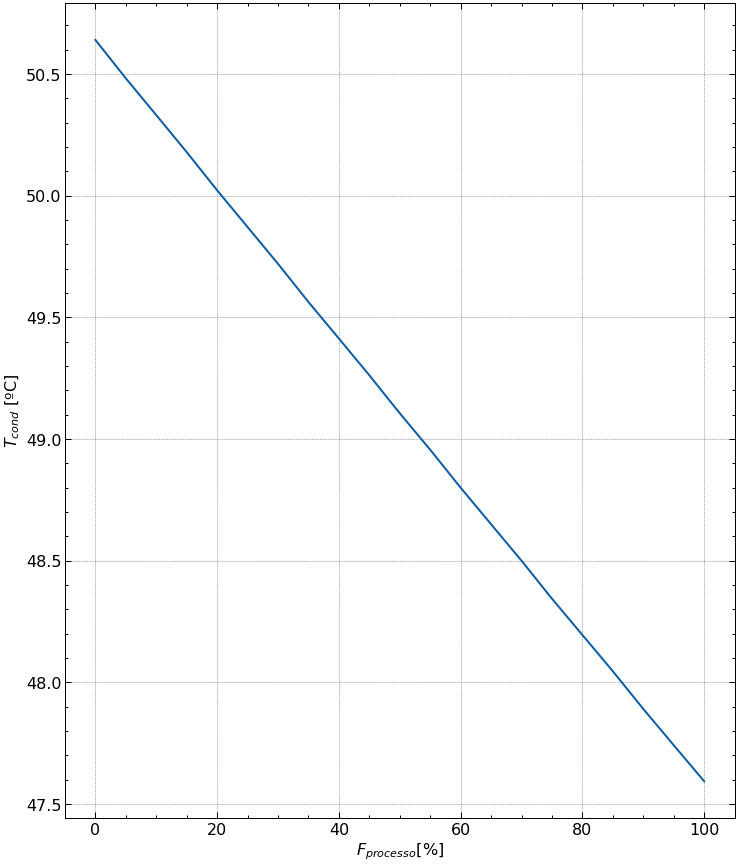

In [43]:
def tcondfpro():

    global Tcond_novo
    Tcond_novo = []

    for c in range(len(var_F)):
        Tcond_novo.append(array_solved[c][3] - 273.15)

    figure = plt.figure(figsize=(12, 15))
    plt.plot(arange(0, 100+5, 5), Tcond_novo)
    plt.xlabel(r'$F_{processo}$[%]')
    plt.ylabel(r'$T_{cond}$ [ºC]')
    plt.show()

tcondfpro()

Gráfico da eficiência em função do processo

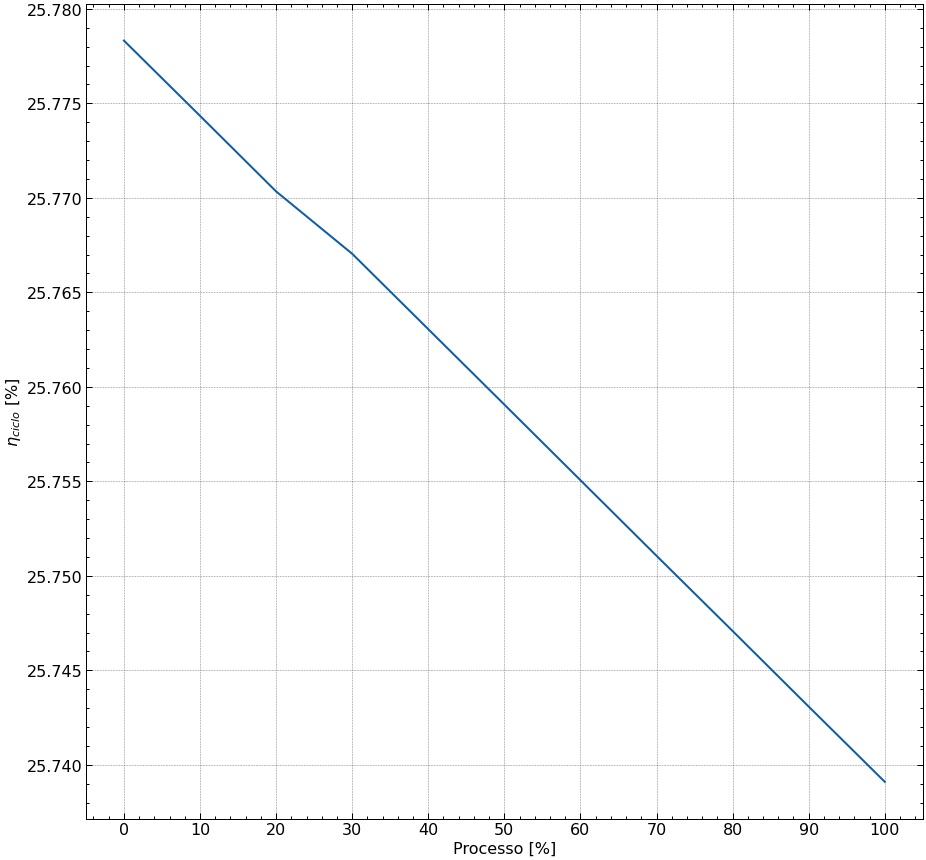

In [44]:
def graph_efi_var():
    n_ciclo_varT = []
    var_F_porc = list(map(lambda x: x*100, var_F))

    for i in range(len(var_F)):
        if i % 2 ==0:
            n_ciclo_varT.append(n_ciclo(p8=P[7], t1=T[0], tcond=array_solved[i][3], m1=array_m_nseimais[i][0], m2=array_m_nseimais[i][1], m3=array_m_nseimais[i][2], m4=array_m_nseimais[i][3], m6=array_m_nseimais[i][5], m8=array_m_nseimais[i][7], m10=array_m_nseimais[i][9]))
        else:
            pass
    figure = plt.figure(figsize=(15, 15))
    plt.plot(arange(0,110, 10), n_ciclo_varT)
    plt.xticks(arange(0,110, 10))
    plt.ylabel('$\eta_{ciclo}$ [%]')
    plt.xlabel('Processo [%]')
    plt.show()

graph_efi_var()

Desenvolver a análise de primeira lei para o esquema de caldeira abaixo. 
Considerar que este sistema está inserido dentro do ciclo de potência já desenvolvido 
(Fig. 1).


![Caldeira](img/Caldeira.jpeg "Caldeira")

In [45]:
P_CH4 = 0.85
P_C2H6 = 0.08
P_C3H8 = 0.05
P_C4H10 = 0.02

P_C02 = 0.0121
P_N2 = 0.0089
P_O2 = 0.0001

P_N2_Ar = 0.79
P_O2_Ar = 0.21

e = 1.5

In [46]:
import numpy as np

In [47]:
m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12 = array_m[20]

In [48]:
h1 = st1(p8=P[7], t1=T[0]).h
h8 = st8(p8=P[7]).h


In [49]:
CH4 = np.array([1,4,0,0])
C2H6 = np.array([2,6,0,0])
C3H8 = np.array([3,8,0,0])
C4H10 = np.array([4,10,0,0])
CO2 = np.array([1,0,2,0])
N2 = np.array([0,0,0,2])
O2 = np.array([0,0,2,0])
H2O = np.array([0,2,1,0])

MM = np.array([12.011,1.008,15.999,14.007])
P_GN = [P_CH4,P_C2H6,P_C3H8,P_C4H10,P_C02,P_N2,P_O2]

M_CH4 = np.sum(CH4*MM)
M_C2H6 = np.sum(C2H6*MM)
M_C3H8 = np.sum(C3H8*MM)
M_C4H10 = np.sum(C4H10*MM)
M_CO2 = np.sum(CO2*MM)
M_N2 = np.sum(N2*MM)
M_O2 = np.sum(O2*MM)
M_H2O = np.sum(H2O*MM)
M_Air = M_N2*P_N2_Ar+M_O2*P_O2_Ar

M = [M_CH4,M_C2H6,M_C3H8,M_C4H10,M_CO2,M_N2,M_O2,M_N2,M_H2O]

F_M = []
for i in range(0,4):
    F_M.append(P_GN)

np.array(F_M)
quant_atomos_comb = np.array([CH4,C2H6,C3H8,C4H10,CO2,N2,O2])
m_comp_comb = np.sum(F_M*quant_atomos_comb.T,axis=1)
m_comp_comb[2] = m_comp_comb[2]*(-1)

P_GN.append(P_N2_Ar/P_O2_Ar) 
P_GN.append(P_O2_Ar/P_O2_Ar) 

b = m_comp_comb[0]
c = m_comp_comb[1]/2
a = e*(m_comp_comb[2] + 2*b + c)/(2*P_GN[8])
d = (m_comp_comb[3] + 2*a*P_GN[7])/2
f = (2*e*(2*b+c)/(2*P_GN[8])-c-2*b)/2

BLNC = [1,1,1,1,1,1,1,a,a]

resposta = np.zeros((9,4))
quant_atomos_molecula = np.array([CH4,C2H6,C3H8,C4H10,CO2,N2,O2,N2,O2])

for i in range(0,9):
    for j in range(0,4):
        resposta[i,j] = quant_atomos_molecula[i,j] * MM[j] * P_GN[i] * BLNC[i]

fuel = resposta[0:7,0:4]
air = resposta[7:9,0:4]
soma = np.sum(resposta)
M_fuel = np.sum(fuel) 
soma_air = np.sum(air) 
total_elem = np.sum(fuel, axis=0,keepdims=True) 

F_tot = total_elem/M_fuel

PCS = 33900*F_tot[0,0] + 141800*(F_tot[0,1] - (F_tot[0,2]/8))

w = PCS/2440 - 9*F_tot[0,1]
F_w = w/M_fuel

PCI = PCS - 2440*(9*F_tot[0,1] - F_w)

ȦḞ = a*(1+79/21)
AF = ȦḞ*(M_Air/M_fuel)

print('A razão ar-combustível é de %.2f kg/kg\n' %AF)

elem = ['C', 'H', 'O', 'N']

for i in range(0,4):
    print(f'A razão {elem[i]}-combustível é de {round(F_tot[0,i],2)} kg/kg\n')

if e == 1:
    print('Mistura estequiométrica (e = 1)\n')
else:
    print(f'Mistura com {int((e-1)*100)}% de excesso de ar (e = {e})\n')
    
print('O PCI é de %.2f kJ/kg' %PCI)

A razão ar-combustível é de 24.08 kg/kg

A razão C-combustível é de 0.74 kg/kg

A razão H-combustível é de 0.22 kg/kg

A razão O-combustível é de 0.02 kg/kg

A razão N-combustível é de 0.01 kg/kg

Mistura com 50% de excesso de ar (e = 1.5)

O PCI é de 54261.33 kJ/kg


In [50]:
data_coef_bal = {
    'a': [a],
    'b': b,
    'c': c,
    'd': d,
    'f': f
}

df_coef_bal = DataFrame(data_coef_bal).style.hide(axis='index')

display(df_coef_bal)

a,b,c,d,f
3.539850,1.252100,2.240000,13.325479,1.186050


In [51]:
import ipywidgets as wd
from sympy import var

In [52]:
def agoravai():
    fld = fluido

    m_fuel = m1*(h1-h8)/(PCI*n_cald)

    m_air = AF*m_fuel
    m_gas = m_air + m_fuel
    m13 = m8
    m14 = m_fuel
    m15 = 0.1*m_air
    m16 = 0.2*m_air
    m22 = 0.7*m_air
    m23 =  m22
    m17 = m16
    m18 = m_gas
    m19 = m18
    m20 = m19
    m21 = m20

    fld2 = 'Air'

    T_amb = 20 + 273.15 #K
    P_amb = 101.325 #kPa

    T15 = T_amb 
    T16 = T_amb
    T8 = T[7]
    T20 = 200 + 273.15 #K
    P20 = P_amb
    P8 = P[7]

    def myfunction(ΔT13, ΔT17):

        from CoolProp.CoolProp import State as st

        T20 = 200 + 273.15 #K
        T23 = 171.12 + 273.15 #K

        st13 = st(fld, {'P': P8, 'Q': 0})

        T13 = st13.T - ΔT13   

        st13_2 = st(fld, {'P': P8, 'T': T13})
        h13 = st13_2.h

        q13 = m13*(h13-h8)

        st20_1 = st('Water', {'P':P_amb, 'T':T20})
        st20_2 = st('CO2', {'P':P_amb, 'T':T20})
        st20_3 = st('Nitrogen', {'P':P_amb, 'T':T20})

        cp_20 = 0.0997*st20_1.cp+0.1771*st20_2.cp+0.7232*st20_3.cp

        cp_19 = cp_20
        cp_18 = cp_20

        T17 = T16 + 200 + ΔT17  

        st16 = st(fld2, {'P':P_amb, 'T':T_amb})
        st17 = st(fld2, {'P':P_amb, 'T':T17})
        h16 = st16.h
        h17 = st17.h

        st17_1 = st('Water', {'P':P_amb, 'T':T17})
        st17_2 = st('CO2', {'P':P_amb, 'T':T17})
        st17_3 = st('Nitrogen', {'P':P_amb, 'T':T17})

        cp_17 = 0.0997*st20_1.cp+0.1771*st20_2.cp+0.7232*st20_3.cp

        cp_21 = cp_20
        cp_23 = cp_20

        T18, T19, T20, T21  = var('T18, T19, T20, T21')
        EqTemp = [m19*cp_19*(T19-T_amb) + m8*h8 - h13*m13 - m20*cp_20*(T20-T_amb), m18*cp_18*(T18-T_amb) - m17*cp_17*(T17-T_amb) - m19*cp_19*(T19-T_amb), m_fuel*PCI + m17*cp_17*(T17-T_amb)  + h13*m13 +m23*cp_23*(T23 - T_amb)- m1*h1 - m18*cp_18*(T18-T_amb), m20*cp_20*(T20 - T_amb) - m21*cp_21*(T21 - T_amb) - m23*cp_23*(T23 - T_amb)]
        temp = linsolve(EqTemp, T18, T19, T20, T21)
        (T18, T19, T20, T21) =  next(iter(temp))

        Q_disp = m_fuel*PCI + m17*cp_17*(T17-T_amb)
        Q_util = Q_disp - (m_gas*cp_18*(T18-T_amb))
        η_forn = round(Q_util/Q_disp,4)

        df = DataFrame()
        Valores = [T13,T17,T18,T19,T20,T21, η_forn*100]
        for i in range(0,6):
            Valores[i] = round((Valores[i]-273.15),2)

        data = {'Valores':Valores}
        df = DataFrame(data, index=['T13 [°C]','T17 [°C]','T18 [°C]','T19 [°C]','T20 [°C]', 'T21 [°C]','η fornalha [%]'])
        df.style.hide_index()
        return df

    slider_ΔT13 = wd.IntSlider(min=30, max=100, step=10)
    slider_ΔT17 = wd.IntSlider(min=-100, max=100, step=10)
    return wd.interact(myfunction, ΔT13=slider_ΔT13, ΔT17=slider_ΔT17), m_fuel, m_air

tab_temp, m_fuel, m_air = agoravai()

interactive(children=(IntSlider(value=30, description='ΔT13', min=30, step=10), IntSlider(value=0, description…

In [53]:
print('A vazão mássica de combustível é de %.2f kg/s' %m_fuel)
print('A vazão mássica de ar é de %.2f kg/s' %m_air)

A vazão mássica de combustível é de 1.76 kg/s
A vazão mássica de ar é de 42.42 kg/s


## Exportando tabelas pro excel ##

In [55]:
def save_xls(dict_df, path):

    writer = ExcelWriter(path)
    for key in dict_df:
        dict_df[key].to_excel(writer, key, index=False)

    writer.save()

dict_df = {
    'Entradas': df,
    'Estados': df_st,
    'Resultados': df_res,
    'm(F_processo)': df_m,
    'Variação com F_processo': df_solved,
    'data_coef_bal': df_coef_bal
}

res_input = str(input('Deseja exportar planilhas para o Excel? s ou n:'))

if res_input == 's':
    try:
        path_input = str(input('Insira o caminho pasta em que deseja salvar:')) + '/' +'resultados.xlsx'
        save_xls(dict_df, path_input)
        print('Exportado com sucesso!')
    except:
        print('Caminho inválido!')

elif res_input == 'n':
    print('Fim!')
else:
    print('Resposta incorreta')

Exportado com sucesso!
